<a href="https://colab.research.google.com/github/Olga-1911/Initial-tuning-of-weights-of-fully-connected-and-convolutional-neural-networks/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B8_%D0%9B%D0%B0%D0%B1_%D1%80%D0%B0%D0%B1_5_2_%D1%87%D0%B0%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа № 5**

**Начальная настройка весов полностью связанных
и сверточных нейронных сетей**

1. Импорт необходимых библиотек и настройка среды

In [21]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from sklearn.neural_network import BernoulliRBM
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2. Загрузка и подготовка данных

In [22]:
# Загрузка набора данных CIFAR-10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Нормализация изображений
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Преобразование меток в one-hot representation
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

3. Определение базовой CNN-модели

In [23]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

4. Метод №1: Автоэнкодер (Autoencoder)

In [24]:
# Построим автоэнкодер
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Декодер
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Создаем модель автоэнкодера
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Обучаем автоэнкодер
#train_images = np.asarray(train_images)
autoencoder.fit(train_images, train_images, epochs=10, batch_size=128, validation_split=0.2)

# Создаем новую CNN-модель
ae_model = build_cnn_model((32, 32, 3), 10)

# Получаем веса из первого слоя автоэнкодера (Conv2D)
pre_trained_weights = autoencoder.layers[1].get_weights() # Индекс 1, т.к. 0 это Input

# Устанавливаем веса в первый слой CNN-модели, но только если shapes совместимы
# Важно убедиться, что первый слой CNN - Conv2D
if len(ae_model.layers) > 0 and isinstance(ae_model.layers[0], Conv2D):
    ae_model.layers[0].set_weights(pre_trained_weights)
else:
    print("Предупреждение: Первый слой CNN не является Conv2D, веса не установлены.")

# Замораживаем первый слой CNN, чтобы он не обновлялся во время обучения
ae_model.layers[0].trainable = False

# Обучаем модель с весами, предварительно обученными на автоэнкодере
ae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_ae = ae_model.fit(train_images, train_labels, epochs=15, batch_size=128, validation_split=0.2)

# Тестируем модель
loss_ae, acc_ae = ae_model.evaluate(test_images, test_labels)
print(f'\nTest accuracy (Autoencoder): {acc_ae:.4f}')

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 380ms/step - loss: 0.0244 - val_loss: 0.0074
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 380ms/step - loss: 0.0070 - val_loss: 0.0061
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 375ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 376ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 375ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 375ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 373ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 363ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 116s 371ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 363ms/step - loss: 0.0042 - val_loss: 0.0040


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 296ms/step - accuracy: 0.3759 - loss: 1.9993 - val_accuracy: 0.3243 - val_loss: 3.5429
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 293ms/step - accuracy: 0.5379 - loss: 1.2976 - val_accuracy: 0.6218 - val_loss: 1.0856
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 294ms/step - accuracy: 0.6090 - loss: 1.0997 - val_accuracy: 0.6611 - val_loss: 0.9777
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 294ms/step - accuracy: 0.6596 - loss: 0.9729 - val_accuracy: 0.6794 - val_loss: 0.9227
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 294ms/step - accuracy: 0.6888 - loss: 0.8696 - val_accuracy: 0.6888 - val_loss: 0.9063
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 303ms/step - accuracy: 0.7282 - loss: 0.7752 - val_accuracy: 0.6941 - val_loss: 0.8926
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 291ms/step - accuracy: 0.7544 - loss: 0.6847 - val_accuracy: 0.7098 - val_loss: 0.8671
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 291ms/step - accuracy: 0.7858 - los

5. Метод №2: RBM (Restricted Boltzmann Machines)

In [ ]:
# Используем RBM для предварительной инициализации весов
rbm = BernoulliRBM(n_components=512, learning_rate=0.01, batch_size=128, n_iter=10, random_state=42)
rbm.fit(train_images.reshape(-1, 32*32*3))

# Получаем компоненты RBM
rbm_weights = rbm.components_

# Создаем новую CNN-модель с весом, взятым из RBM
rbm_model = build_cnn_model((32, 32, 3), 10)

# Проверяем, что первый слой - Conv2D
if isinstance(rbm_model.layers[0], Conv2D):
    # Трансформируем веса RBM в формат, подходящий для Conv2D слоя
    # Предполагаем, что первый слой Conv2D имеет 32 фильтра размером 3x3
    # и 3 входных канала (RGB)
    n_filters = 32
    kernel_size = (3, 3)
    input_channels = 3

    # Проверяем, что размерность rbm_weights соответствует ожиданиям
    if rbm_weights.shape == (512, 3072):
        # Создаем веса сверточного слоя нужной формы
        conv_weights = np.zeros((kernel_size[0], kernel_size[1], input_channels, n_filters))

        # Вычисляем необходимое количество весов для одного фильтра
        weights_per_filter = kernel_size[0] * kernel_size[1] * input_channels  # 3 * 3 * 3 = 27

        for i in range(n_filters):
            # Выбираем случайный ВЕКТОР из RBM для каждого фильтра
            random_index = np.random.randint(0, rbm_weights.shape[0])
            rbm_vector = rbm_weights[random_index]

            # Заполняем веса фильтра значениями из RBM вектора
            # Так как векторов RBM 512,  а элементов в фильтре 27,  берем остаток от деления
            for kh in range(kernel_size[0]):
                for kw in range(kernel_size[1]):
                    for ic in range(input_channels):
                        index = (kh * kernel_size[1] + kw) * input_channels + ic
                        conv_weights[kh, kw, ic, i] = rbm_vector[index % rbm_vector.shape[0]]

        # Создаем смещения
        conv_biases = np.zeros(n_filters)

        # Устанавливаем веса в сверточный слой
        rbm_model.layers[0].set_weights([conv_weights, conv_biases])
    else:
        print(f"Ошибка: Неожиданная форма весов RBM: {rbm_weights.shape}")
else:
    print("Ошибка: Первый слой модели не является Conv2D слоем.")

# Обучаем модель с весами, предварительно обученными на RBM
history_rbm = rbm_model.fit(train_images, train_labels, epochs=15, batch_size=128, validation_split=0.2)

# Тестируем модель
loss_rbm, acc_rbm = rbm_model.evaluate(test_images, test_labels)
print(f'\nTest accuracy (RBM): {acc_rbm:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 112s 345ms/step - accuracy: 0.3436 - loss: 2.1933 - val_accuracy: 0.4084 - val_loss: 1.8473
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 344ms/step - accuracy: 0.4891 - loss: 1.4173 - val_accuracy: 0.4981 - val_loss: 1.5085
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 108s 343ms/step - accuracy: 0.5605 - loss: 1.2356 - val_accuracy: 0.5468 - val_loss: 1.2911
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 362ms/step - accuracy: 0.6101 - loss: 1.1056 - val_accuracy: 0.6301 - val_loss: 1.0518
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 112s 357ms/step - accuracy: 0.6570 - loss: 0.9745 - val_accuracy: 0.6434 - val_loss: 1.0512
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 342ms/step - accuracy: 0.6859 - loss: 0.8826 - val_accuracy: 0.6358 - val_loss: 1.0582
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 106s 337ms/step - accuracy: 0.7217 - loss: 0.7917 - val_accuracy: 0.6071 - val_loss: 1.1345
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 105s 337ms/step - accuracy: 0.7473 -

6. Метод №3: K-Means Clustering

In [10]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
import random

# --- ПАРАМЕТРЫ -------------------------------------------------
n_clusters   = 32        # число фильтров в первом Conv2D
patch_size   = 3         # размер патча (3×3×3)
n_patches    = 20000     # сколько патчей выбираем из train_images
# --------------------------------------------------------------

# 1) Извлечение случайных патчей 3×3×3 из train_images
H, W, C = 32, 32, 3
patches = np.zeros((n_patches, patch_size*patch_size*C), dtype=np.float32)
for i in range(n_patches):
    img_idx = random.randrange(train_images.shape[0])
    x = random.randrange(0, H - patch_size + 1)
    y = random.randrange(0, W - patch_size + 1)
    patch = train_images[img_idx, x:x+patch_size, y:y+patch_size, :]  # shape (3,3,3)
    patches[i] = patch.reshape(-1)

# 2) KMeans на патчах
print("KMeans на 3×3×3-патчах…")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=5)
kmeans.fit(patches)
centers = kmeans.cluster_centers_   # (n_clusters, 27)

# 3) Формируем веса для первого Conv2D
#    Conv2D ожидает (kernel_h, kernel_w, in_channels, out_channels)
conv_weights = centers.reshape(n_clusters, patch_size, patch_size, C)
# сейчас shape (32,3,3,3) — но нужно (3,3,3,32), поэтому транспонируем
conv_weights = np.transpose(conv_weights, (1,2,3,0))  # (3,3,3,32)
conv_biases  = np.zeros(n_clusters, dtype=np.float32)

# 4) Строим модель и ставим веса в первый слой
kmeans_model = build_cnn_model((32,32,3), 10)

# на всякий случай ищем первый Conv2D
first_conv = None
for layer in kmeans_model.layers:
    if isinstance(layer, Conv2D):
        first_conv = layer
        break

if first_conv is None:
    raise RuntimeError("В модели нет слоя Conv2D!")
else:
    # проверяем форму
    w_shape, b_shape = first_conv.get_weights()[0].shape, first_conv.get_weights()[1].shape
    print("Ожидается весовой тензор", w_shape, "и bias", b_shape)
    assert w_shape == conv_weights.shape
    assert b_shape == conv_biases.shape
    first_conv.set_weights([conv_weights, conv_biases])
    print("Весa первого Conv2D инициализированы из k-средних.")

# 5) Обучаем и тестируем
history_kmeans = kmeans_model.fit(train_images, train_labels,
                                  epochs=15, batch_size=128,
                                  validation_split=0.2)

loss_kmeans, acc_kmeans = kmeans_model.evaluate(test_images, test_labels)
print(f"\nTest accuracy (K-Means init): {acc_kmeans:.4f}")

KMeans на 3×3×3-патчах…


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Ожидается весовой тензор (3, 3, 3, 32) и bias (32,)
Весa первого Conv2D инициализированы из k-средних.
Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 114s 355ms/step - accuracy: 0.3011 - loss: 2.3855 - val_accuracy: 0.4324 - val_loss: 1.6071
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 323ms/step - accuracy: 0.4358 - loss: 1.5721 - val_accuracy: 0.5153 - val_loss: 1.3631
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 330ms/step - accuracy: 0.4905 - loss: 1.4298 - val_accuracy: 0.5453 - val_loss: 1.2896
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 107s 341ms/step - accuracy: 0.5363 - loss: 1.3082 - val_accuracy: 0.5677 - val_loss: 1.2212
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 107s 340ms/step - accuracy: 0.5667 - loss: 1.2152 - val_accuracy: 0.5583 - val_loss: 1.2686
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 101s 323ms/step - accuracy: 0.6020 - loss: 1.1277 - val_accuracy: 0.6054 - val_loss: 1.1375
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 101s 322ms/step - accuracy: 0.6217 - loss: 1.0649 - val_accuracy:

7. Сравнение результатов

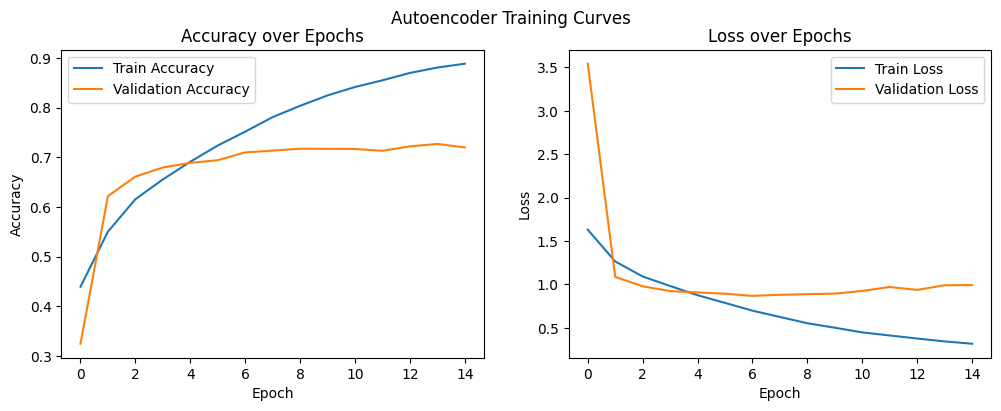

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


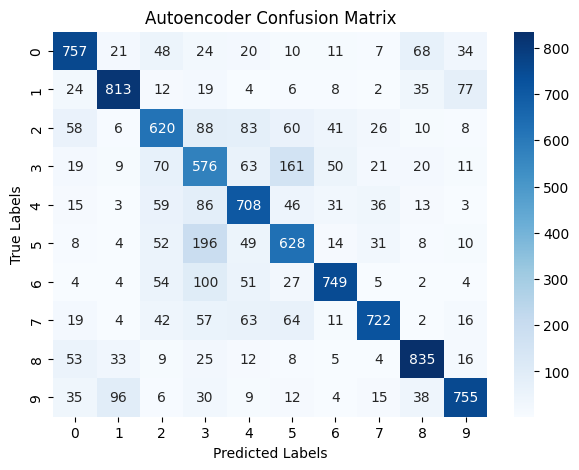

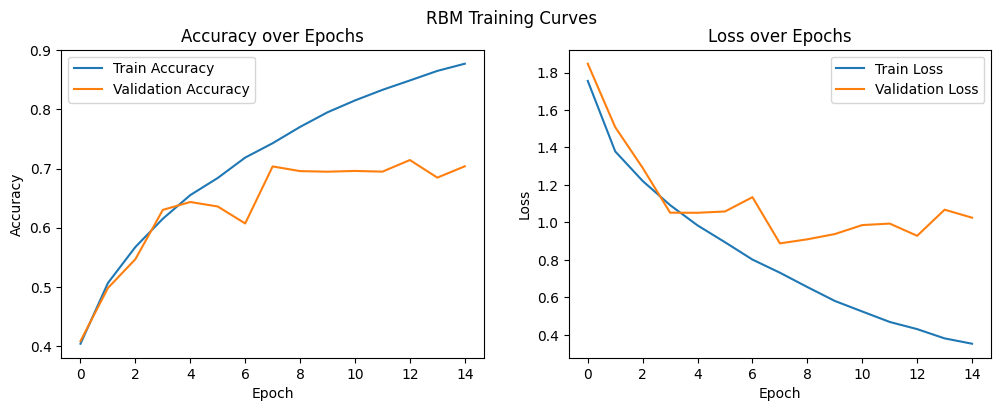

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


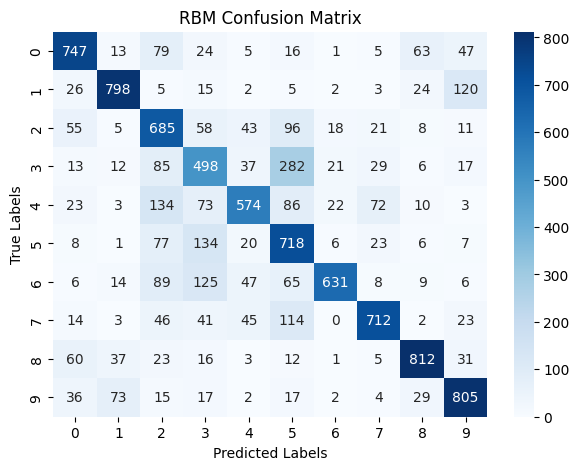

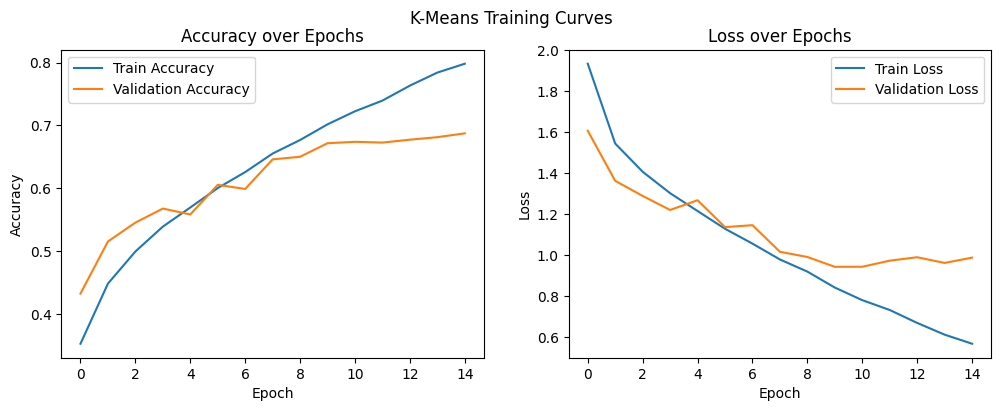

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


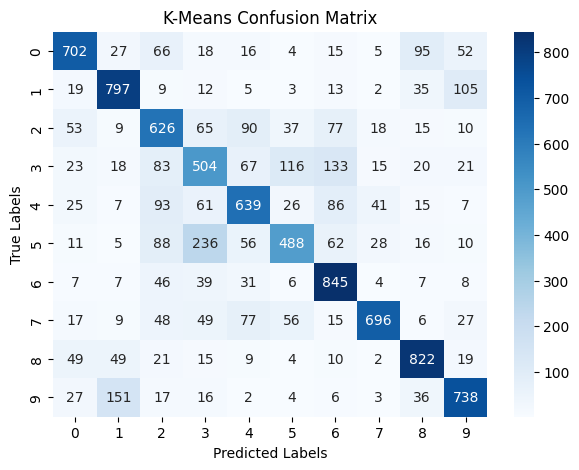


Comparison of Validation Accuracies:
----------------------------------------
Autoencoder: 0.7163
RBM: 0.6980
K-Means: 0.6857


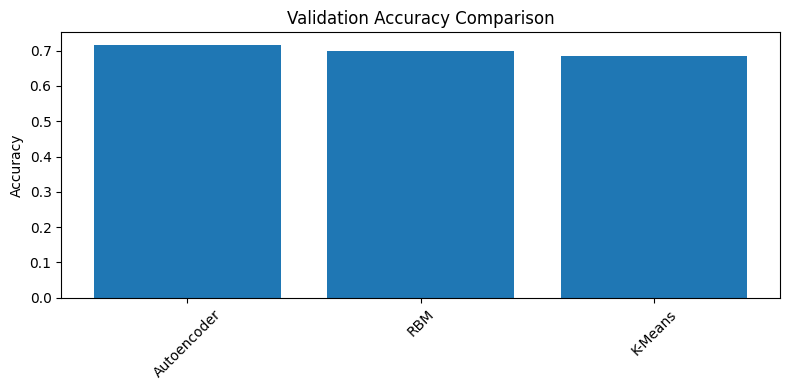

In [27]:
from sklearn.metrics import confusion_matrix

# Функция для построения графика точности и потерь
def plot_training_curves(history, title="Training Curves"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.suptitle(title)
    plt.show()

# Функция для построения матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1))
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# *** Теперь выводим графику ***

# Автоэнкодер
plot_training_curves(history_ae, title="Autoencoder Training Curves")
y_pred_ae = ae_model.predict(test_images)
plot_confusion_matrix(test_labels, y_pred_ae, labels=np.arange(10), title="Autoencoder Confusion Matrix")

# RBM
plot_training_curves(history_rbm, title="RBM Training Curves")
y_pred_rbm = rbm_model.predict(test_images)
plot_confusion_matrix(test_labels, y_pred_rbm, labels=np.arange(10), title="RBM Confusion Matrix")

# K-Means
plot_training_curves(history_kmeans, title="K-Means Training Curves")
y_pred_kmeans = kmeans_model.predict(test_images)
plot_confusion_matrix(test_labels, y_pred_kmeans, labels=np.arange(10), title="K-Means Confusion Matrix")

# Итоговая таблица результатов
results = {
    'Autoencoder': acc_ae,
    'RBM': acc_rbm,
    'K-Means': acc_kmeans
}

print("\nComparison of Validation Accuracies:")
print("-" * 40)
for method, accuracy in results.items():
    print(f"{method}: {accuracy:.4f}")

# Общий итоговый график сравнения точности
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), results.values())
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()